# A/B-тестирование
## Введение

Цель исследования - провести анализ результатов А/В-теста.
У нас имеются данные о действиях новых пользователей в период с 7 декабря 2020 года по 4 января 2021 года, техническое задание, а также несколько вспомогательных датасетов - календарь маркетинговых событий на 2020 год, таблица пользователей, зарегистрировавшихся в период с 7 по 21 декабря, а также таблица участников теста.

Техническое задание:
- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

Необходимо:
* оценить корректность проведения теста
* проанализировать результаты теста

Исследование пройдет в несколько этапов:
* загрузка и предобработка данных
* оценка корректности проведения теста
* исследовательский анализ данных
* оценка результатов А/В-теста с помощью статистических критериев

## Предобработка данных

In [1]:
pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import math as mth
import scipy.stats as st
from datetime import datetime, timedelta

In [3]:
# Загрузим данные.
ab_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
ab_new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
ab_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')


In [4]:
# Посмотрим на датасет с действиями пользователей.
ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [5]:
# Приведем дату к типу datetime и проверим на дубликаты.
ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'])
ab_events.duplicated().sum()

0

In [6]:
# Посмотрим, что содержится в столбце details.
ab_events['details'].unique()

array([ 99.99,   9.99,   4.99, 499.99,    nan])

В столбце 'details' содержатся детали действия, в нашем случае - суммы покупок,а также много пропусков. Этот столбец не будет задействован в анализе, поэтому оставим его без изменений.

In [7]:
# Посмотрим на датасет с маркетинговыми событиями.
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [8]:
# Посмотрим, какие события и регионы содержаться в датасете.
print(marketing_events['name'].unique())
print(marketing_events['regions'].unique())

['Christmas&New Year Promo' "St. Valentine's Day Giveaway"
 "St. Patric's Day Promo" 'Easter Promo' '4th of July Promo'
 'Black Friday Ads Campaign' 'Chinese New Year Promo'
 'Labor day (May 1st) Ads Campaign' "International Women's Day Promo"
 'Victory Day CIS (May 9th) Event' 'CIS New Year Gift Lottery'
 'Dragon Boat Festival Giveaway' "Single's Day Gift Promo"
 'Chinese Moon Festival']
['EU, N.America' 'EU, CIS, APAC, N.America' 'N.America' 'APAC'
 'EU, CIS, APAC' 'CIS']


In [9]:
# Приведем даты к типу datetime.
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

In [10]:
# Проверим на дубликаты.
marketing_events.duplicated().sum()

0

In [11]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [12]:
# Посмотрим на датасет с новыми пользователями.
ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [13]:
# Приведем даты к типу datetime.
ab_new_users['first_date'] = pd.to_datetime(ab_new_users['first_date'])

In [14]:
# Посмотрим на количество уникальных пользователей.
len(ab_new_users['user_id'].unique())

61733

In [15]:
# Посмотрим, какие значения содержатся в столбце с регионом.
ab_new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [16]:
# Посмотрим, какие есть устройства.
ab_new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

In [17]:
# Проверим на дубликаты
ab_new_users.duplicated().sum()

0

In [18]:
ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [19]:
# Посмотрим на датасет с участниками тестов.
ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [20]:
# Посмотрим количество уникальных пользователей.
len(ab_participants['user_id'].unique())

16666

Уникальных пользователей меньше, чем строк в таблице. Скорее всего некоторые пользователи попадают в несколько тестов или групп.

In [21]:
# Посмотрим на столбец с группой.
ab_participants['group'].unique()

array(['A', 'B'], dtype=object)

In [22]:
# Посмотрим на столбец с названием теста
ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [23]:
# Посмотрим на дубликаты.
ab_participants.duplicated().sum()

0

In [24]:
# Посмотрим, не попадают ли пользователи из одного теста сразу в две группы.
ab_participants.duplicated(['user_id', 'ab_test']).sum()

0

In [25]:
# Заранее соберем пользователей, участвующих в двух тестах.
duplicated_users_df = ab_participants[ab_participants['user_id'].duplicated()]
len(duplicated_users_df)

1602

In [26]:
duplicated_users = duplicated_users_df['user_id']

У нас имеются данные о 61 733 уникальных пользователей всех регионов, использованы 4 вида устройств - PC, Android, iPhone и Мас.

Проводится 2 вида тестов - recommender_system_test и interface_eu_test. В тестировании участвует 16 666 уникальных пользователей, из них 1602 пользователя попадают в два теста одновременно, при этом пользователи, попадающие сразу в две группы одного теста, отсутствуют.

## Оценка корректности проведения теста

### Соответствие техническому заданию

In [27]:
# Посмотрим на даты первого и последнего событий.
max_dt_event = ab_events['event_dt'].max()
min_dt_event = ab_events['event_dt'].min()

print(max_dt_event, min_dt_event)

2020-12-30 23:36:33 2020-12-07 00:00:33


В датасете содержаться действия пользователей с 7 по 30 декабря 2020 года, хотя в техническом задании указана дата остановки теста 4 января 2021 года.

In [28]:
# Проверим даты регистрации.
#print(ab_new_users['first_date'].min())
#print(ab_new_users['first_date'].max())

In [29]:
# Посмотрим, как пользователи распределены по регионам.
ab_new_users.groupby('region').agg({'user_id':'nunique'})

,user_id
region,
APAC,3153
CIS,3155
EU,46270
N.America,9155


In [30]:
# Соберем датафрейм с данными о новых пользователях, которые являются участниками теста
df = ab_participants.merge(ab_new_users, on='user_id', how='left')

# Посмотрим на даты решистрации пользователей нашего теста
print('Минимальная дата регистрации', df.query('ab_test == "recommender_system_test"')['first_date'].min())
print('Максимальная дата регистрации', df.query('ab_test == "recommender_system_test"')['first_date'].max())


Минимальная дата регистрации 2020-12-07 00:00:00
Максимальная дата регистрации 2020-12-21 00:00:00


Даты регистрации соответствуют техническому заданию.

In [31]:
# Посмотрим, какие пользователи из каких регионов участвую в тестировании.
df.query('ab_test == "recommender_system_test"')['region'].unique()

array(['EU', 'N.America', 'CIS', 'APAC'], dtype=object)

In [32]:
# Оставим только пользователей Евросоюза.
df = df.query('region == "EU"')
len(df['user_id'].unique())

16316

In [33]:
# Посмотрим, как распределены пользователи, состоящие сразу в двух тестах по группам и 
# решим, стоит ли их удалять.
duplicated_users_by_test = (df.loc[df['user_id'].isin(duplicated_users)]
                            .groupby(['ab_test', 'group'])
                            .agg({'user_id':'nunique'})
                            .rename(columns={'user_id':'count'})
                            .merge(df.groupby(['ab_test', 'group'])
                                     .agg({'user_id':'nunique'})
                                     .rename(columns={'user_id':'total'}),
                                   on=['ab_test', 'group'], how='left')
                            .reset_index()
                          )
duplicated_users_by_test['share'] = round(duplicated_users_by_test['count'] / duplicated_users_by_test['total'], 4)
duplicated_users_by_test

,ab_test,group,count,total,share
0,interface_eu_test,A,819,5831,0.1405
1,interface_eu_test,B,783,5736,0.1365
2,recommender_system_test,A,921,3634,0.2534
3,recommender_system_test,B,681,2717,0.2506


И в тестовой, и в контрольной группах теста recommender_system_test по 25% пользователей, участвующих в другом тесте. Т.к. количество таких пользователей достаточно велико - 1602 человека, их удаление может исказить результаты анализа. Поэтому будем считать, что второй тест оказывает одинаковое влияние на обе группы и оставим пользователей без изменений.

In [34]:
# Оставим только пользователей, участвующих в тесте рекомендательной системы.
df = df.query('ab_test == "recommender_system_test"')
df

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC
...,...,...,...,...,...,...
6346,7C5C12FA1B5AB710,A,recommender_system_test,2020-12-21,EU,Android
6347,91C3969B8A72B908,B,recommender_system_test,2020-12-09,EU,Android
6348,E26F13A65CEAC6EA,A,recommender_system_test,2020-12-17,EU,Mac
6349,95401934D6D6D4FC,B,recommender_system_test,2020-12-13,EU,iPhone


In [35]:
# Посмотрим, какой процент новых пользователей региона EU, зарегистрировавшихся в нужные даты, участвует в тесте.
round(len(df['user_id'].unique())/len(ab_new_users.query('region == "EU" & first_date <= "2020-12-21"')['user_id'].unique()), 2)

0.15

Таким образом, у нас осталось 6351 уникальный пользователь, которые соответствуют критериям - 15% новых пользователей региона EU, которые зарегистрировались не позднее 21 декабря. Выше мы уже проверили, что каждый пользователь состоит только в одной группе, контрольной либо тестовой.

### Маркетинговые активности во время теста

In [36]:
# Посмотрим, есть ли пересечение событий теста с маркетинговыми активностями.
eu_marketing_events = marketing_events.loc[marketing_events['regions'].str.contains('EU')]
eu_marketing_events.query('@min_dt_event < start_dt < @max_dt_event or @min_dt_event < finish_dt < @max_dt_event')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Получается, что время проведения теста совпало с Christmas & New Year Promo. Но эта активность началась с 25 декабря 2020 года, когда набор новых пользователей был уже остановлен. А также эта активность скорее всего оказала влияние на обе группы - и тестовую, и контрольную.

### Анализ аудитории теста

In [37]:
# Посмотрим, равномерно ли распределены пользователи по группам.
df.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
A,3634
B,2717


In [38]:
# Добавим события в датасет с отфильтрованными пользователями.
df = df.merge(ab_events, on='user_id', how='left')


In [39]:
len(df)

26290

In [40]:
# Посчитаем лайфтам событий и оставим события каждого пользователя не больше чем за 14 дней (13-й лайфтайм).
df['lifetime'] = (df['event_dt'] - df['first_date']).dt.days
df = df.loc[(df['lifetime'] < 14) | df['lifetime'].isna()]
df

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,lifetime
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,0.0
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,0.0
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,0.0
6,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,NaN,0.0
8,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
26285,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-15 20:10:06,product_page,NaN,1.0
26286,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-20 20:01:34,product_page,NaN,6.0
26287,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-14 05:48:50,login,NaN,0.0
26288,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-15 20:10:03,login,NaN,1.0


In [41]:
df['lifetime'].unique()

array([ 0.,  1.,  5.,  3., 10.,  4.,  6., 11., nan,  8.,  2.,  7., 13.,
        9., 12.])

In [42]:
len(df)

25490

В результате оценки корректности проведения теста была обнаружена погрешность в данных - тест был остановлен 30 декабря 2020 года вместо 4 января 2021 года. В тесте приняли участие 15% новых пользователей региона EU, количество участников - 6351 человек. В датасете оставлены только события пользователей за 14 дней.

## Исследовательский анализ данных
### Количество событий на пользователя



In [43]:
# Подготовим данные для визуализаии.
events_by_user = df.groupby('user_id').agg({'group':'first', 'event_dt':'nunique'})
events_by_user.head()

,group,event_dt
user_id,,
000ABE35EE11412F,A,0
001064FEAAB631A1,B,6
0010A1C096941592,A,7
001C05E87D336C59,A,0
00341D8401F0F665,A,2


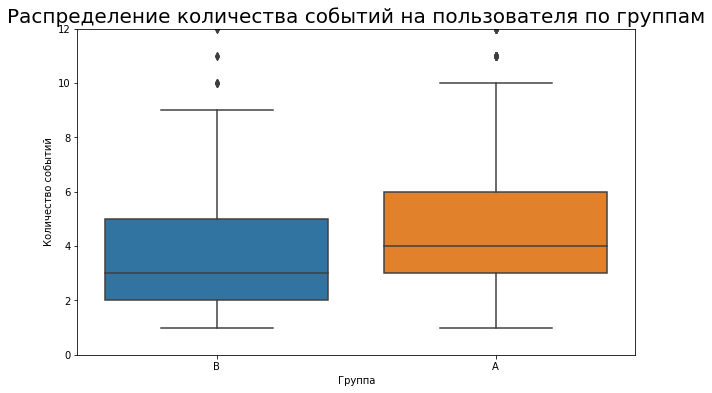

In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='event_dt', data=events_by_user.query('event_dt > 0'))
plt.ylim(0, 12)
plt.title('Распределение количества событий на пользователя по группам', fontsize=20)
plt.xlabel('Группа')
plt.ylabel('Количество событий')
plt.show()

Количество событий на пользователя распределено не равномерно, медианное количество событий на человека в группе А - 4 выше, чем в группе В. Заметим, что у некоторых пользователей нет никаких действий. Посмотрим на них внимательнее.

In [45]:
# Заметим, что некторые пользователи не совершили ни одного события. 
# Посмотрим, много ли их и как они распределены по группам.
zero_events_users = (df[df['event_name'].isna()]
                       .groupby('group')
                       .agg({'user_id':'nunique'})
                       .rename(columns={'user_id':'count'})
                       .join(df.groupby('group')
                             .agg({'user_id':'nunique'})
                             .rename(columns={'user_id':'total'})))
zero_events_users['share'] = round(zero_events_users['count'] / zero_events_users['total'], 2)
zero_events_users

,count,total,share
group,,,
A,1030,3634,0.28
B,1840,2717,0.68


Пользователей, не совершивших никаких действий, примерно половина от всего датафрейма. Причем они распределены не равномерно - 68% в тестовой группе и 28% в контрольной. Возможно, это тоже показатель изменений?

In [46]:
# Посмотрим также на среднее количество событий на пользователя по типу события.
events_by_name = (df.groupby(['user_id', 'event_name'])
                    .agg({'group':'first', 'event_dt':'count'})
                    .reset_index()
                    .sort_values(by='event_dt'))
events_by_name.head()

,user_id,event_name,group,event_dt
7155,EBDE231E67FBEF9D,product_page,A,1
619,146880B18CE204A9,product_page,A,1
4724,9E656B4D34C68949,login,A,1
4725,9E656B4D34C68949,product_page,A,1
1687,37A0A1F3FB2F01F4,product_cart,B,1


<Figure size 720x432 with 0 Axes>

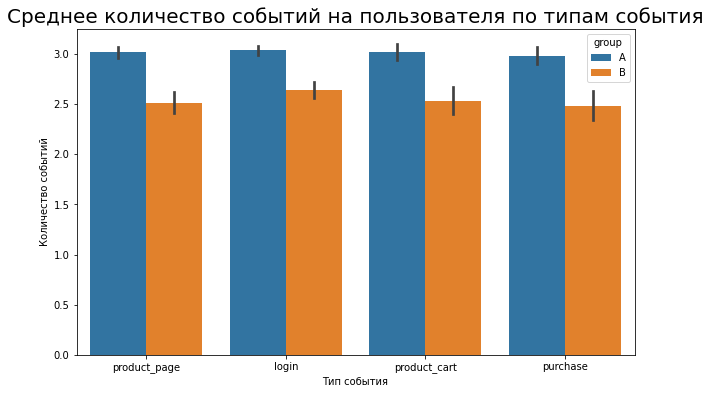

In [47]:
plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
sns.barplot(x='event_name', y='event_dt', data=events_by_name, hue='group')
plt.title('Среднее количество событий на пользователя по типам события', fontsize=20)
plt.xlabel('Тип события')
plt.ylabel('Количество событий')
plt.show()

Пользователи контрольной группы в среднем совершают больше событий всех типов, чем пользователи тестовой группы.

### События по дням

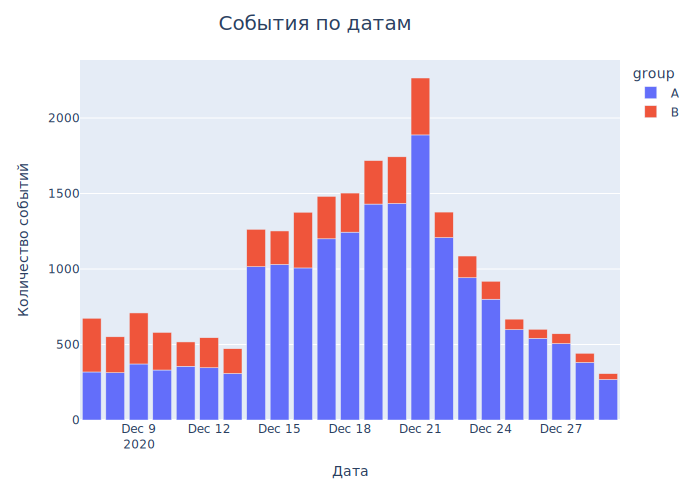

In [56]:
# Посмотрим на количество событий по дням
df['event_day'] = df['event_dt'].dt.date
events_by_days = df.groupby(['group', 'event_day']).agg({'event_dt':'count'}).reset_index()
fig = px.bar(events_by_days, x='event_day', y='event_dt', color='group')
fig.update_layout(title=dict(text='События по датам',font=dict(size=20), x=0.45),
                  xaxis_title='Дата',
                  yaxis_title='Количество событий')
fig.show('svg')

С 14 декабря резко увеличивается количество событий и достигает своего пика 21 декабря, похоже, что количество покупок увеличивается перед праздниками. Также можно отметить, что в группе А пользователи в целом совершают гораздо больше событий, чем в группе В, однако, в начале тестирования 7-9 декабря количество событий в обеих группах одинаковое. Но из-за неравного количества пользователей в группах имеет смысл посмотреть на относительное количество событий.

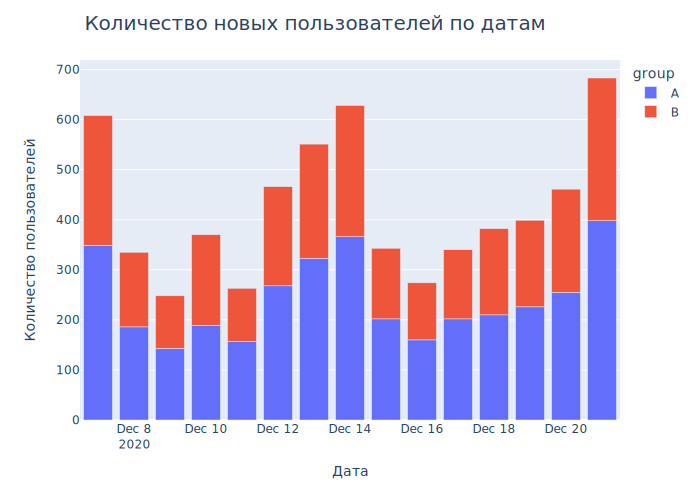

In [57]:
# Посмотрим на набор новых пользователей по дням.
new_users_by_days = df.groupby(['group', 'first_date']).agg({'user_id':'nunique'}).reset_index()
fig = px.bar(new_users_by_days, x='first_date', y='user_id', color='group')
fig.update_layout(title=dict(text='Количество новых пользователей по датам',font=dict(size=20), x=0.45),
                  xaxis_title='Дата',
                  yaxis_title='Количество пользователей')
fig.show('svg')

При анализе динамики набора новых пользователей видно, что 14 и 21 декабря пришло их наибольшее количество, скорее всего с этим связано значительное увеличение количества событий в эти даты.

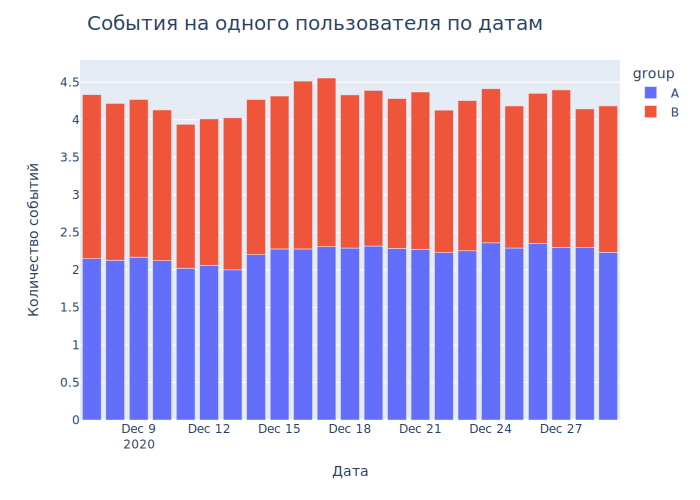

In [58]:
# Посмотрим, как распределено количество событий на одного пользователя по датам
events_by_days_per_user = df.groupby(['group', 'event_day']).agg({'event_dt':'count','user_id':'nunique'}).reset_index()
events_by_days_per_user['per_user'] = events_by_days_per_user['event_dt'] / events_by_days_per_user['user_id']
fig = px.bar(events_by_days_per_user, x='event_day', y='per_user', color='group')
fig.update_layout(title=dict(text='События на одного пользователя по датам',font=dict(size=20), x=0.45),
                  xaxis_title='Дата',
                  yaxis_title='Количество событий')
fig.show('svg')

На графике видим, что количество событий в среднем на одного пользователя во все дни примерно одинаково, кроме 30 декабря 2020 года, когда пользователи из группы А совсем не совершали событий.

### Конверсия по группам

In [51]:
# Посмотрим на воронки и конверсию из регистрации по группам.
conversion = (df.pivot_table(index='event_name',
                            columns='group', 
                            values='user_id', 
                            aggfunc='nunique')
                .reset_index())
conversion['conversion_A'] = round(conversion['A'] / len(df.query('group == "A"')['user_id'].unique()), 3) * 100
conversion['conversion_B'] = round(conversion['B'] / len(df.query('group == "B"')['user_id'].unique()), 3) * 100
conversion

group,event_name,A,B,conversion_A,conversion_B
0,login,2604,876,71.7,32.2
1,product_cart,782,244,21.5,9.0
2,product_page,1685,493,46.4,18.1
3,purchase,833,249,22.9,9.2


In [52]:
# Переименуем названия событий, чтобы собрать их в нужном порядке
conversion['event_name'] = conversion['event_name'].replace({'login':'1_login', 'product_page':'2_product_page',
                                                            'product_cart':'3_product_cart', 'purchase':'4_purchase'})
conversion = conversion.sort_values(by='event_name')

Последовательность событий в воронке:

* авторизация (login)
* просмотр страницы товара (product_page)
* просмотр корзины (product_cart)
* покупка (purchase)


Заметим, что чаще встречается покупка без перехода в корзину. Скорее всего, для покупки необязательно переходить в корзину.

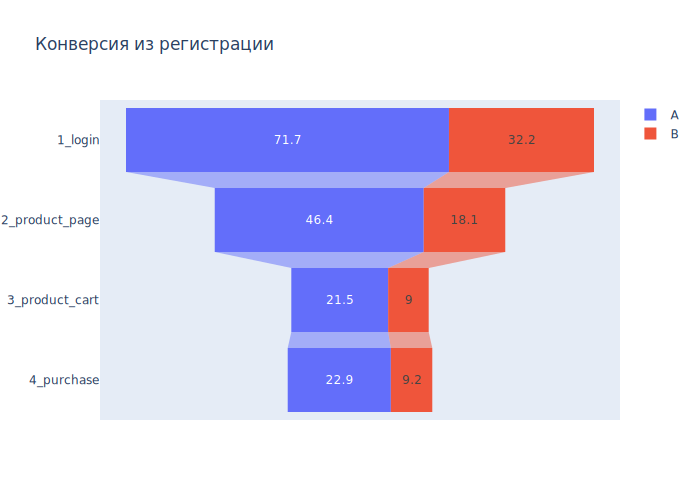

In [59]:
# Визуализируем воронку.
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = conversion['event_name'],
    x = conversion['conversion_A'],
    textinfo = "value"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = conversion['event_name'],
    x = conversion['conversion_B'],
    textposition = "inside",
    textinfo = "value"))
fig.update_layout(title='Конверсия из регистрации')
fig.show('svg')

Конверсия из регистрации для тестовой группы почти в 2 раза ниже, чем конверсия в контрольной группе. Это странно, неужели изменения в рекомендациях смогли так повлиять на пользователей? Кажется, что-то не так с приложением в тестовой группе.

Конверсия в покупку у контрольной и тестовой группы 22,9% и 9,2% соответственно.

## Оценка результатов А/В-теста
Датасет скорректирован по датам набора пользователей, региону и количеству пользователей в соответствии с техническим заданием. В выборку для тестирования попали пользователи, одновременно участвующие в другом тестировании, но т.к. они содержаться в каждой группе в равных долях, принято решение считать, что эти пользователи оказывают одинаковое влияние на группы. Также последние события в тесте произошли 30 декабря 2020 года, хотя заявленная дата окончания теста - 4 января 2021. Возможно, было принято решение окончить тест раньше, т.к. в новогодние праздники обычно наблюдается существенный спад активности пользователей.
По результатам А/В-теста можно заметить очень сильное падение конверсии из регистрации в покупку в тестовой группе, при этом значительно возросла доля пользователей, не проявляющих активность после регистрации - 68% в тестовой против 28% в контрольной.


### Статистическая разница долей

Проверим наличие статистически значимых различий между группами. Для этого сформулируем гипотезы и напишем функцию, которая будет применять z-критерий к 2 группам по определенному событию.

**Н0:** нет различий в конверсии между выборками.

**Н1:** есть различия в конверсии между выборками.

In [54]:
# Функция для определения статистической достоверности различия долей в группах

def get_z(df, c, group1, group2, alpha):
    event = c
    
# Сначала сформируем таблицу с количеством пользователей по группам по выбранному событию
    events_by_groups = (df.query('event_name == @event')
                          .groupby('group')
                          .agg({'user_id':'nunique'})
                          .rename(columns={'user_id':'user_count'}))
    
# Добавим общее количество пользователей в группах   
    events_by_groups = (events_by_groups.merge(df.groupby('group')
                                        .agg({'user_id':'nunique'})
                                        .rename(columns={'user_id':'total_users'}), on='group'))
    
# Добавим столбец с конверсией    
    events_by_groups['conversion'] = round(events_by_groups['user_count'] / events_by_groups['total_users'], 4)
    
# Определим уровень значимости   
    alpha = alpha
    
# Подготовим данные к расчету z-критерия
    p1 = events_by_groups['conversion']['A']
    p2 = events_by_groups['conversion']['B']
    p_combined = ((events_by_groups['user_count'][group1] + events_by_groups['user_count'][group2]) / 
            (events_by_groups['total_users'][group1] + events_by_groups['total_users'][group2]))
    
    print(events_by_groups['user_count'][group1], events_by_groups['user_count'][group2], events_by_groups['total_users'][group1], events_by_groups['total_users'][group2])
    diff = p1 - p2
    
# Посчитаем z_value   
    z_value = diff / mth.sqrt(p_combined * (1 - p_combined)
                          * (1/events_by_groups['total_users'][group1] + 1/events_by_groups['total_users'][group2]))
    
# Зададим нормальное распределение   
    distr = st.norm(0, 1)
    
# Посчитаем p_value    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    bonferroni_alpha = alpha/3
    
    print(f'Событие {c} в группах {group1} и {group2}')
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу, между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print()

In [55]:
# Применим функцию ко всем событиям, при этом не забудем исключить Nan, чтобы функция сработала корректно.
group_1 = 'A'
group_2 = 'B'

for c in df.query('~event_name.isna()')['event_name'].unique():
    get_z(df, c, group_1, group_2, 0.05)
    


833 249 3634 2717
Событие purchase в группах A и B
Отвергаем нулевую гипотезу, между долями есть значимая разница

782 244 3634 2717
Событие product_cart в группах A и B
Отвергаем нулевую гипотезу, между долями есть значимая разница

1685 493 3634 2717
Событие product_page в группах A и B
Отвергаем нулевую гипотезу, между долями есть значимая разница

2604 876 3634 2717
Событие login в группах A и B
Отвергаем нулевую гипотезу, между долями есть значимая разница



При уровне значимости 0,05 между конверсиями тестовой и контрольной групп имеются статистически значимые различия.

## Общий вывод

**Исследовательский анализ.**

Медианное количество событий на пользователя в группе А больше, чем в группе В, распределение группы В сильнее смещено к 0. Скорее всего это произошло из-за большой доли "нулевых" пользователей в этой группе - тех, кто только зарегистрировался и не совершал больше никаких действий. В группе В 68% таких пользователей, в А - 28%.

Пик активности пользователей приходится на период с 14 по 21 декабря 2020 года, после чего активость идет на спад. Заметим, что маркетинговое событие Christmas & New Year Promo, начавшееся 25 декабря 2020 года не сильно повлияло на поведение пользователей - в этот приод не наблюдается никаких всплесков активности. Также стоит отметить, что в начале теста с 7 по 9 декабря количество событий в обеих группах примерно одинаково, но дальше количество событий, совершенных пользователями контрольной группы значительно превосходит количество событий тестовой группы. Скорее всего такой эффект произошел из-за существенно большоего количества пользователей, набранных в эти дни. При этом среднее количество событий на пользователя по всем датам в обеих группах примерно одинаково.

Конверсия в покупку в контрольной группе упала почти в два раза - с 22,9% до 9,2%. Возможно, это внесенное в приложение изменение стало причиной технического сбоя. Однако, до покупки доходит 49% залогинившихся пользователей группы А и 51% залогинившихся пользователей группы В. Похоже, что что-то происходит между регистрацией и авторизацией в приложении - может быть, у пользователи возникают сложности с авторизацией. Возможно, технический сбой.

Воронка событий выглядит следующим образом:
* авторизация (login)
* просмотр страницы товара (product_page)
* просмотр корзины (product_cart)
* покупка (purchase)



**А/В-тест.**

Для анализа статистического различия между группами проведен z-тест с поправкой на множественность (Бонферрони). Тесты проведенные с уровнями значимости 0,05 выявили значимые статистические различия между контрольной и тестовой группами на всех шагах. 

Учитывая значительное снижение конверсии, можно заключить, что изменение системы рекомендаций заметно отрицательно сказалось на пользователях. Считаю, что можно признать тест корректным, т.к. соблюдены даты, количество пользователей, каждый пользователь попал только в одну группу, пользователи параллельного теста равномерно распределены по группам. Немного смущает различие в количестве пользователей в группах, но это не влияет на изучаемую конверсию, т.к. это относительный показатель.
